In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flowers-dataset/README.dataset.txt
/kaggle/input/flowers-dataset/README.roboflow.txt
/kaggle/input/flowers-dataset/valid/dandelion/33857574164_b0b724b567_n_jpg.rf.7b99dd4c5c099777768ab5129a29d570.jpg
/kaggle/input/flowers-dataset/valid/dandelion/6495802659_98b57e0cca_m_jpg.rf.1095124909c35debcea108ed07d44eb9.jpg
/kaggle/input/flowers-dataset/valid/dandelion/15378782362_4161b23af7_m_jpg.rf.5660236373de659a56b40ae54cc25e61.jpg
/kaggle/input/flowers-dataset/valid/dandelion/5607983792_f8b8766ff7_jpg.rf.011e016018d8373dccd60fe8440e0992.jpg
/kaggle/input/flowers-dataset/valid/dandelion/3451646670_3eff7094b7_n_jpg.rf.392c7bc357ebcc2a645e68178f2cec0e.jpg
/kaggle/input/flowers-dataset/valid/dandelion/3696596109_4c4419128a_m_jpg.rf.003cb976f4403bbf6aae622d629d9841.jpg
/kaggle/input/flowers-dataset/valid/dandelion/2477231067_3aecef1bf8_n_jpg.rf.21cb5619be696e0ad2514e94537b766c.jpg
/kaggle/input/flowers-dataset/valid/dandelion/2628514700_b6d5325797_n_jpg.rf.4248eeeba8c3b6c1fce3721c83

# Mounting the dataset (Daisy -Danderlion)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alsaniipe/flowers-dataset")

print("Path to dataset files:", path)

# Importing the Libraries

In [2]:
# Cell 1: Imports & Setup
import os
import random
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import timm
from timm.data import resolve_model_data_config

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.multiprocessing as mp

# To Avoid any warnings 
warnings.filterwarnings("ignore", category=UserWarning)

#mp.set_start_method('forkserver', force=True)
mp.set_start_method('spawn', force=True)

# Checking the Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# Model Finder

In [3]:
avail_pretrained_models = timm.list_models('*davit*',pretrained=True)
print(len(avail_pretrained_models))
avail_pretrained_models

5


['davit_base.msft_in1k',
 'davit_base_fl.msft_florence2',
 'davit_huge_fl.msft_florence2',
 'davit_small.msft_in1k',
 'davit_tiny.msft_in1k']

# Config and Hyper Parameters

In [4]:
# Cell 2: Configuration

CFG = {
    # reproducibility
    'seed':            42,

    # data paths
    'train_directory':       '/kaggle/input/flowers-dataset/train',
    'val_directory':         '/kaggle/input/flowers-dataset/valid',
    'test_directory':        '/kaggle/input/flowers-dataset/test',
    'batch_size':      32,
    'num_workers':     2,

    # model
    'model_name':      'davit_base.msft_in1k',

    # training
    'num_epochs':      15,
    'learning_rate':   1e-3,
    #'step_size':       7,
    #'scheduler_gamma': 0.1,

    # optimizer: 'Adam', 'AdamW', 'SGD'
    'optimizer_name':  'AdamW',
    'weight_decay':    0.0,
    'sgd_momentum':    0.9,

    # loss: 'cross_entropy', 'focal', 'cross_entropy_w'
    'loss_fn':         'focal',
    'focal_alpha':     0.25,
    'focal_gamma':     2.0,

    # outputs
    'save_path':       './models',
    'results_dir':     './results'
}

os.makedirs(CFG['save_path'],   exist_ok=True)
os.makedirs(CFG['results_dir'], exist_ok=True)


# Defining Seed

In [5]:
# Cell 3: Seed Everything
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG['seed'])


# Checking Model Config

In [6]:
data_config = resolve_model_data_config(CFG['model_name'])
print("\n",data_config)

print("Section runs successfully")


 {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
Section runs successfully


# Model Calling and Datatransforms

In [7]:
# Cell 4: Helpers—Model & Transforms
def get_model(model_name, num_classes, device=device):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(device)



# Necessary Data Transforms



def get_data_transforms(model_name, is_training=False):
    # instantiate & derive config, then discard
    temp_model = timm.create_model(model_name, pretrained=True)
    cfg = resolve_model_data_config(temp_model)
    input_size = cfg.get('input_size', (3,224,224))[1:]
    mean       = cfg.get('mean',       (0.485,0.456,0.406))
    std        = cfg.get('std',        (0.229,0.224,0.225))
    del temp_model

    print(f"\n[INFO] Creating {'train' if is_training else 'val/test'} transforms")
    print(f"[INFO] Input size={input_size}, mean={mean}, std={std}")

    transform_list = []
    if is_training:
        transform_list += [
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandAugment(num_ops=2, magnitude=9)
        ]
    else:
        transform_list += [
            transforms.Resize([int(x/0.95) for x in input_size]),
            transforms.CenterCrop(input_size)
        ]
    transform_list += [
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]
    return transforms.Compose(transform_list)


# Data Loaders with Reproduicibility

In [8]:
# Cell 5: DataLoaders with Reproducibility
def seed_worker(worker_id):
    """
    Called on each dataloader worker to ensure its RNG is seeded
    deterministically from the master seed.
    """
    worker_seed = CFG['seed'] + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


# Dataloaders
def get_dataloaders():
    # 1) Prepare transforms
    train_tf = get_data_transforms(CFG['model_name'], is_training=True)
    val_tf   = get_data_transforms(CFG['model_name'], is_training=False)

    # 2) Build datasets
    train_dataset       = datasets.ImageFolder(CFG['train_directory'], transform=train_tf)
    vaidation_dataset   = datasets.ImageFolder(CFG['val_directory'],   transform=val_tf)
    test_dataset        = datasets.ImageFolder(CFG['test_directory'],  transform=val_tf)

    # 3) Create a fixed‐seed generator for shuffling
    g = torch.Generator()
    g.manual_seed(CFG['seed'])

    # 4) DataLoaders with seeded workers
    train_loader = DataLoader(train_dataset,batch_size=CFG['batch_size'],shuffle=True,num_workers=CFG['num_workers'],pin_memory=True,generator=g)
        #worker_init_fn=seed_worker,
    
    val_loader   = DataLoader(vaidation_dataset,batch_size=CFG['batch_size'],shuffle=False,num_workers=CFG['num_workers'],pin_memory=True)

    
    test_loader  = DataLoader(test_dataset,batch_size=CFG['batch_size'],shuffle=False,num_workers=CFG['num_workers'],pin_memory=True)
        #worker_init_fn=seed_worker

    return train_loader, val_loader, test_loader, train_dataset.classes


# def load_model(model_name, num_classes, epoch, path):
#     model = get_model(model_name, num_classes, device)
#     fn    = os.path.join(path, f"{model_name}_epoch_{epoch}.pth")
#     model.load_state_dict(torch.load(fn, map_location=device))
#     return model


# Compute Class Weights

In [9]:
# Cell 6: Compute & Print Class Counts + Weights
train_loader, val_loader, test_loader, class_names = get_dataloaders()
num_classes = len(class_names)

counts    = Counter(train_loader.dataset.targets)
weights_np= compute_class_weight(class_weight='balanced',classes=np.arange(num_classes),y=train_loader.dataset.targets)

class_weights = torch.tensor(weights_np, dtype=torch.float32).to(device)

print(f"\n{'Idx':>3s}  {'Class':<20s}  {'#Samples':>8s}  {'Weight':>8s}")
print("-"*45)
#print("\n")
for idx, name in enumerate(class_names):
    print(f"{idx:3d}  {name:<20s}  {counts[idx]:8d}  {class_weights[idx]:8.4f}")



[INFO] Creating train transforms
[INFO] Input size=(224, 224), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)

[INFO] Creating val/test transforms
[INFO] Input size=(224, 224), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)

Idx  Class                 #Samples    Weight
---------------------------------------------
  0  daisy                      529    1.2051
  1  dandelion                  746    0.8546


# Focal Loss Definition and Optimizers

In [10]:
# Cell 7: FocalLoss, Criterion & Optimizer Factories
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
        self.weight, self.reduction = weight, reduction

    def forward(self, logits, targets):
        logpt = F.log_softmax(logits, dim=1)
        pt    = torch.exp(logpt)
        logpt = logpt.gather(1, targets.unsqueeze(1)).view(-1)
        pt    = pt.gather(1, targets.unsqueeze(1)).view(-1)
        mod   = (1 - pt) ** self.gamma
        loss  = -self.alpha * mod * logpt
        if self.weight is not None:
            at   = self.weight.gather(0, targets)
            loss = loss * at
        return loss.mean() if self.reduction=='mean' else loss.sum()

def make_criterion():
    if CFG['loss_fn']=='cross_entropy_w':
        return nn.CrossEntropyLoss(weight=class_weights)
    elif CFG['loss_fn']=='cross_entropy':
        return nn.CrossEntropyLoss()
    elif CFG['loss_fn']=='focal':
        return FocalLoss(alpha=CFG['focal_alpha'], gamma=CFG['focal_gamma'], weight=class_weights)
    else:
        raise ValueError(CFG['loss_fn'])

def make_optimizer(model):
    opt = CFG['optimizer_name'].lower()
    if opt=='adam':
        return optim.Adam(model.parameters(), lr=CFG['learning_rate'], weight_decay=CFG['weight_decay'])
    if opt=='adamw':
        return optim.AdamW(model.parameters(), lr=CFG['learning_rate'], weight_decay=CFG['weight_decay'])
    if opt=='sgd':
        return optim.SGD(model.parameters(), lr=CFG['learning_rate'],momentum=CFG['sgd_momentum'],weight_decay=CFG['weight_decay'])
    raise ValueError(CFG['optimizer_name'])


# Plotting Metrices and Confusion Matrix and Classification Report

In [11]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = list(range(1, len(train_losses) + 1))

    # Loss Plot
    plt.figure()
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')  # blue circle markers
    plt.plot(epochs, val_losses, 'rs-', label='Val Loss')      # red square markers
    plt.xticks(epochs)  # Force integer ticks on x-axis
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(CFG['results_dir'], f"loss_curve_{CFG['model_name']}.png"))
    plt.show()
    plt.close()

    # Accuracy Plot
    plt.figure()
    plt.plot(epochs, train_accuracies, 'g^-', label='Train Acc')  # green triangle markers
    plt.plot(epochs, val_accuracies, 'md-', label='Val Acc')      # magenta diamond markers
    plt.xticks(epochs)  # Force integer ticks on x-axis
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(CFG['results_dir'], f"accuracy_curve_{CFG['model_name']}.png"))
    plt.show()
    plt.close()



print("Section runs successfully")



Section runs successfully


In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings  # Just use warnings
from sklearn.metrics import classification_report

# Ignore UndefinedMetricWarning
#warnings.filterwarnings("ignore", category=UserWarning)  # Filter UserWarnings in general

# def plot_confusion_matrix(conf_matrix, class_names, model_name, save_dir='./results'):
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
    
#     # Save figure
#     os.makedirs(save_dir, exist_ok=True)
#     save_path = os.path.join(save_dir, f"confusion_matrix_{model_name}.png")
#     plt.savefig(save_path)
#     print(f"Confusion matrix saved to: {save_path}")
    
#     plt.show()
#     plt.close()


def plot_confusion_matrix(conf_matrix, class_names, model_name, save_dir='./results'):
    n = len(class_names)
    # scale factors (you can tweak these)
    width_per_class  = 0.6
    height_per_class = 0.6
    min_width, min_height = 8, 6

    fig_width  = max(min_width,  n * width_per_class)
    fig_height = max(min_height, n * height_per_class)

    plt.figure(figsize=(fig_width, fig_height))
    
    sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)

    # rotate x‐ticks if many classes
    if n > 10:
        plt.xticks(rotation=45, ha='right')
    else:
        plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Save figure
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"confusion_matrix_{model_name}.png")
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Confusion matrix saved to: {save_path}")

    plt.show()
    plt.close()



def evaluate_and_save(model, dataloader, class_names, save_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_labels = []
   
    model.to(device)

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    
    # Using zero_division=1 to handle undefined metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=1)

    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\n Test Accuracy: {acc:.4f}\n")
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))
    print("Confusion Matrix:\n", conf_matrix)

    # Plot Confusion Matrix
    plot_confusion_matrix(conf_matrix, class_names, CFG['model_name'], save_dir)


    # Save to Excel
    os.makedirs(save_dir, exist_ok=True)
    report_df = pd.DataFrame(report).transpose()
    conf_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    with pd.ExcelWriter(f"{save_dir}/Test_Metrics_{CFG['model_name']}.xlsx") as writer:
        report_df.to_excel(writer, sheet_name='Classification_Report')
        conf_df.to_excel(writer, sheet_name='Confusion_Matrix')

    print(f"\nResults saved to: {save_dir}/test_metrics.xlsx")

    return acc, report_df, conf_df
    

print("Section runs successfully")

Section runs successfully


# Main Training Loop and Checkpointing

In [15]:
# # Cell 9: Main Training Loop + Best‐only Checkpointing
# def run_training():
#     tr_loader, vl_loader, ts_loader, class_names = get_dataloaders()

#     model     = get_model(CFG['model_name'], len(class_names), device)
#     criterion = make_criterion()
#     optimizer = make_optimizer(model)
#     scheduler = lr_scheduler.StepLR(
#         optimizer,
#         step_size=CFG['step_size'],
#         gamma=CFG['scheduler_gamma']
#     )

#     history = {'t_loss':[], 't_acc':[], 'v_loss':[], 'v_acc':[]}
#     best_val_loss = float('inf')
#     best_val_acc  = 0.0

#     for ep in range(1, CFG['num_epochs']+1):
#         # — Train —
#         model.train()
#         tloss = tcorrect = ttotal = 0
#         for x,y in tqdm(tr_loader, desc=f"Epoch {ep} Train", leave=False):
#             x,y = x.to(device), y.to(device)
#             optimizer.zero_grad()
#             out  = model(x)
#             loss = criterion(out, y)
#             loss.backward()
#             optimizer.step()

#             tloss    += loss.item() * x.size(0)
#             tcorrect+= (out.argmax(1)==y).sum().item()
#             ttotal  += y.size(0)
#         tr_loss, tr_acc = tloss/ttotal, tcorrect/ttotal

#         # — Validate —
#         model.eval()
#         vloss = vcorrect = vtotal = 0
#         with torch.no_grad():
#             for x,y in tqdm(vl_loader, desc=f"Epoch {ep} Val", leave=False):
#                 x,y = x.to(device), y.to(device)
#                 out  = model(x)
#                 loss = criterion(out, y)
#                 vloss    += loss.item() * x.size(0)
#                 vcorrect+= (out.argmax(1)==y).sum().item()
#                 vtotal  += y.size(0)
#         val_loss, val_acc = vloss/vtotal, vcorrect/vtotal

#         # step LR
#         scheduler.step()

#         # record history
#         history['t_loss'].append(tr_loss)
#         history['t_acc'].append(tr_acc)
#         history['v_loss'].append(val_loss)
#         history['v_acc'].append(val_acc)

#         print(f"Ep{ep}: tr_loss {tr_loss:.4f}, tr_acc {tr_acc:.4f} | "
#               f"val_loss {val_loss:.4f}, val_acc {val_acc:.4f}")

#         # — Check for new best val_loss —
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             path = os.path.join(
#                 CFG['save_path'],
#                 f"{CFG['model_name']}_best_val_loss.pth"
#             )
#             torch.save(model.state_dict(), path)
#             print(f"  ↓ New best val_loss ({best_val_loss:.4f}), saved to {path}")

#         # — Check for new best val_acc —
#         if val_acc > best_val_acc:
#             best_val_acc = val_acc
#             path = os.path.join(
#                 CFG['save_path'],
#                 f"{CFG['model_name']}_best_val_acc.pth"
#             )
#             torch.save(model.state_dict(), path)
#             print(f"  ↑ New best val_acc ({best_val_acc:.4f}), saved to {path}")

#     print(f"\nTraining complete. Best val_loss: {best_val_loss:.4f}, Best val_acc: {best_val_acc:.4f}")
#     plot_metrics(history['t_loss'], history['v_loss'], history['t_acc'], history['v_acc'])
#     return history

# # run training
# history = run_training()


# Cell 9: Main Training Loop + Best‐only Checkpointing + LR Printout
def run_training():
    train_loader, validation_loader, test_loader, class_names = get_dataloaders()

    print(f"\n 🚀 Model Name: {CFG['model_name']}\n"
          f"Total Class: {len(class_names)}\n"
          f"Optimizer Used: {CFG['optimizer_name']}\n"
          f"Initial Learning Rate:{CFG['learning_rate']}\n"
          f"Batch Size: {CFG['batch_size']}\n"
          f"Loss Function Used: {CFG['loss_fn']}\n")

    best_validation_loss_epoch_num =0
    best_validation_accuracy_epoch_num=0

    model     = get_model(CFG['model_name'], len(class_names), device)
    
    criterion = make_criterion()
    
    optimizer = make_optimizer(model)
    
    #scheduler = lr_scheduler.StepLR(optimizer,step_size=CFG['step_size'],gamma=CFG['scheduler_gamma'])
    

    history = {'Training_Loss':[], 'Training_Accuracy':[], 'Validation_Loss':[], 'Validation_Accuracy':[], 'lr':[]}
    best_val_loss = float('inf')
    best_val_acc  = 0.0

    for ep in range(1, CFG['num_epochs']+1):
        # — Get & record current LR —
        current_lr = optimizer.param_groups[0]['lr']
        
        history['lr'].append(current_lr)

        # — Train —
        model.train()
        tloss = tcorrect = ttotal = 0
        for x,y in tqdm(train_loader, desc=f"Epoch {ep}/{CFG['num_epochs']} Train", leave=False):
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out  = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            tloss    += loss.item() * x.size(0)
            tcorrect+= (out.argmax(1)==y).sum().item()
            ttotal  += y.size(0)
        tr_loss, tr_acc = tloss/ttotal, tcorrect/ttotal

        # — Validate —
        model.eval()
        vloss = vcorrect = vtotal = 0
        with torch.no_grad():
            for x,y in tqdm(validation_loader, desc=f"Epoch {ep}/{CFG['num_epochs']} Validation", leave=False):
                x,y = x.to(device), y.to(device)
                out  = model(x)
                loss = criterion(out, y)
                vloss    += loss.item() * x.size(0)
                vcorrect+= (out.argmax(1)==y).sum().item()
                vtotal  += y.size(0)
        val_loss, val_acc = vloss/vtotal, vcorrect/vtotal

        # — Step LR scheduler for next epoch —
        #scheduler.step()

        # — Record history —
        history['Training_Loss'].append(tr_loss)
        history['Training_Accuracy'].append(tr_acc)
        history['Validation_Loss'].append(val_loss)
        history['Validation_Accuracy'].append(val_acc)
        #history['Learning Rate'].append(current_lr)

        # — Print stats including LR —
        print(
            f"\n ✅ Epoch Number:{ep} \n Learning Rate: {current_lr:.6f} | \n"
            f"   📉 Training_loss {tr_loss:.4f}, Training_Accuracy {tr_acc:.4f} | \n"
            f"   📈 Validation_loss {val_loss:.4f}, Validation_Accuracy {val_acc:.4f}\n"
        )

        # — Save if best val_loss —
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_validation_loss_epoch_num=ep
            path = os.path.join(
                CFG['save_path'],
                f"{CFG['model_name']}_best_val_loss.pth"
            )
            torch.save(model.state_dict(), path)
            print(f"  ↓ 🏆 New best val_loss ({best_val_loss:.4f}), saved to {path}")

        # — Save if best val_acc —
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_validation_accuracy_epoch_num=ep
            path = os.path.join(
                CFG['save_path'],
                f"{CFG['model_name']}_best_val_acc.pth"
            )
            torch.save(model.state_dict(), path)
            print(f"  ↑ 🔥 New best val_acc ({best_val_acc:.4f}), saved to {path}")

    metrics_df =pd.DataFrame({
            'Epochs': list(range(1, CFG['num_epochs']+1)),
            'Train Loss': history['Training_Loss'],
            'Validation Loss': history['Validation_Loss'],
            'Training Accuracy': history['Training_Accuracy'],
            'Validation Accuracy': history['Validation_Accuracy']
        })
        
    print(
        f"\nTraining complete. \n"
        f"Best Validation_loss: {best_val_loss:.4f}, \n"
        f"Best Validation Loss Epoch Number: {best_validation_loss_epoch_num}\n"
        f"Best Validation_Accuracy: {best_val_acc:.4f}\n"
        f"Best Validation Accuracy Epoch Number:{best_validation_accuracy_epoch_num}\n"
    )
    log_path = os.path.join(CFG['results_dir'], f"Training_Log_{CFG['model_name']}.xlsx")
    metrics_df.to_excel(log_path, index=False)
    print(f"[✔] Training log saved to: {log_path}")

    plot_metrics(history['Training_Loss'],history['Validation_Loss'],history['Training_Accuracy'],history['Validation_Accuracy'])
    return history



# Start Training


[INFO] Creating train transforms
[INFO] Input size=(224, 224), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)

[INFO] Creating val/test transforms
[INFO] Input size=(224, 224), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)

 🚀 Model Name: davit_base.msft_in1k
Total Class: 2
Optimizer Used: AdamW
Initial Learning Rate:0.001
Batch Size: 32
Loss Function Used: focal



Epoch 1/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 1/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:1 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0264, Training_Accuracy 0.8345 | 
   📈 Validation_loss 0.0208, Validation_Accuracy 0.8516

  ↓ 🏆 New best val_loss (0.0208), saved to ./models/davit_base.msft_in1k_best_val_loss.pth
  ↑ 🔥 New best val_acc (0.8516), saved to ./models/davit_base.msft_in1k_best_val_acc.pth


Epoch 2/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 2/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:2 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0153, Training_Accuracy 0.8933 | 
   📈 Validation_loss 0.0112, Validation_Accuracy 0.8901

  ↓ 🏆 New best val_loss (0.0112), saved to ./models/davit_base.msft_in1k_best_val_loss.pth
  ↑ 🔥 New best val_acc (0.8901), saved to ./models/davit_base.msft_in1k_best_val_acc.pth


Epoch 3/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 3/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:3 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0199, Training_Accuracy 0.8847 | 
   📈 Validation_loss 0.0103, Validation_Accuracy 0.9313

  ↓ 🏆 New best val_loss (0.0103), saved to ./models/davit_base.msft_in1k_best_val_loss.pth
  ↑ 🔥 New best val_acc (0.9313), saved to ./models/davit_base.msft_in1k_best_val_acc.pth


Epoch 4/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 4/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:4 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0120, Training_Accuracy 0.9176 | 
   📈 Validation_loss 0.0156, Validation_Accuracy 0.9093



Epoch 5/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 5/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:5 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0142, Training_Accuracy 0.9098 | 
   📈 Validation_loss 0.0072, Validation_Accuracy 0.9451

  ↓ 🏆 New best val_loss (0.0072), saved to ./models/davit_base.msft_in1k_best_val_loss.pth
  ↑ 🔥 New best val_acc (0.9451), saved to ./models/davit_base.msft_in1k_best_val_acc.pth


Epoch 6/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 6/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:6 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0087, Training_Accuracy 0.9451 | 
   📈 Validation_loss 0.0104, Validation_Accuracy 0.9396



Epoch 7/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 7/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:7 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0112, Training_Accuracy 0.9373 | 
   📈 Validation_loss 0.0236, Validation_Accuracy 0.8764



Epoch 8/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 8/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:8 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0156, Training_Accuracy 0.9114 | 
   📈 Validation_loss 0.0096, Validation_Accuracy 0.9203



Epoch 9/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 9/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:9 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0110, Training_Accuracy 0.9271 | 
   📈 Validation_loss 0.0104, Validation_Accuracy 0.9451



Epoch 10/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 10/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:10 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0078, Training_Accuracy 0.9537 | 
   📈 Validation_loss 0.0087, Validation_Accuracy 0.9588

  ↑ 🔥 New best val_acc (0.9588), saved to ./models/davit_base.msft_in1k_best_val_acc.pth


Epoch 11/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 11/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:11 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0092, Training_Accuracy 0.9467 | 
   📈 Validation_loss 0.0060, Validation_Accuracy 0.9588

  ↓ 🏆 New best val_loss (0.0060), saved to ./models/davit_base.msft_in1k_best_val_loss.pth


Epoch 12/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 12/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:12 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0090, Training_Accuracy 0.9498 | 
   📈 Validation_loss 0.0064, Validation_Accuracy 0.9615

  ↑ 🔥 New best val_acc (0.9615), saved to ./models/davit_base.msft_in1k_best_val_acc.pth


Epoch 13/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 13/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:13 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0091, Training_Accuracy 0.9357 | 
   📈 Validation_loss 0.0087, Validation_Accuracy 0.9396



Epoch 14/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 14/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:14 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0101, Training_Accuracy 0.9412 | 
   📈 Validation_loss 0.0113, Validation_Accuracy 0.9203



Epoch 15/15 Train:   0%|          | 0/40 [00:05<?, ?it/s]

Epoch 15/15 Validation:   0%|          | 0/12 [00:00<?, ?it/s]


 ✅ Epoch Number:15 
 Learning Rate: 0.001000 | 
   📉 Training_loss 0.0090, Training_Accuracy 0.9475 | 
   📈 Validation_loss 0.0063, Validation_Accuracy 0.9615


Training complete. 
Best Validation_loss: 0.0060, 
Best Validation Loss Epoch Number: 11
Best Validation_Accuracy: 0.9615
Best Validation Accuracy Epoch Number:12

[✔] Training log saved to: ./results/Training_Log_davit_base.msft_in1k.xlsx


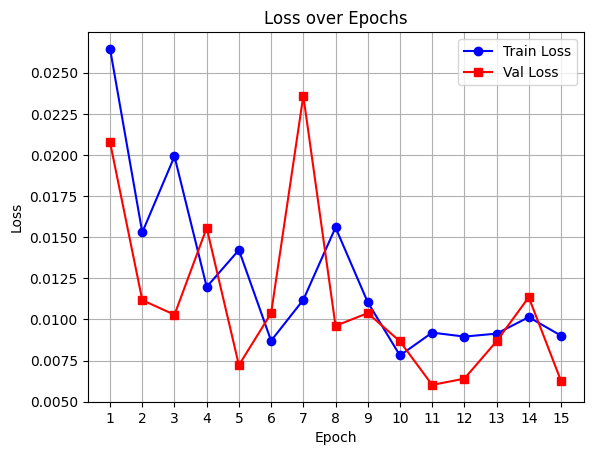

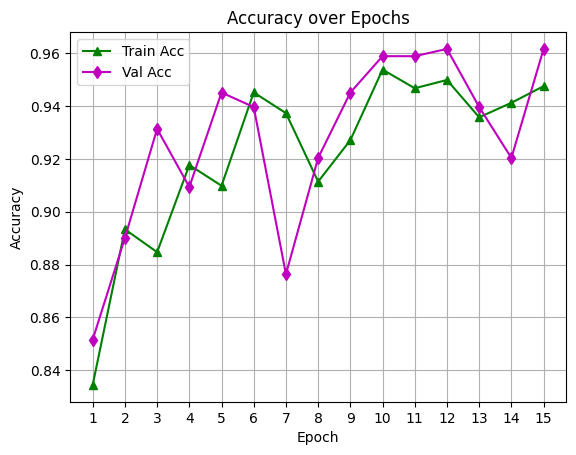

In [16]:
# run training

history = run_training()

# Load Model From Saved Checkpoint

In [17]:
def load_model(model_name: str,num_classes: int,load_type: int,path: str) -> torch.nn.Module:
    """
    load_type:
      0 → load a specific epoch checkpoint (requires `epoch` be set)
      1 → load best_val_loss check point
      2 → load best_val_acc  checkpoint
    """
    # 1) build fresh model
    model = get_model(model_name, num_classes, device)

    # 2) pick filename
    if load_type == 1:
        fname = f"{model_name}_best_val_loss.pth"
    elif load_type == 2:
        fname = f"{model_name}_best_val_acc.pth"
    else:
        if epoch is None:
            raise ValueError("`epoch` must be provided when load_type=0")
        fname = f"{model_name}_epoch_{epoch}.pth"

    fn = os.path.join(path, fname)

    # 3) load weights
    state = torch.load(fn, map_location=device)
    model.load_state_dict(state)

    return model


# Final Evaluation


[INFO] Creating train transforms
[INFO] Input size=(224, 224), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)

[INFO] Creating val/test transforms
[INFO] Input size=(224, 224), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)

 Test Accuracy: 0.9670

Classification Report:
               precision    recall  f1-score   support

       daisy       0.95      0.97      0.96        77
   dandelion       0.98      0.96      0.97       105

    accuracy                           0.97       182
   macro avg       0.96      0.97      0.97       182
weighted avg       0.97      0.97      0.97       182

Confusion Matrix:
 [[ 75   2]
 [  4 101]]
Confusion matrix saved to: ./results/confusion_matrix_davit_base.msft_in1k.png


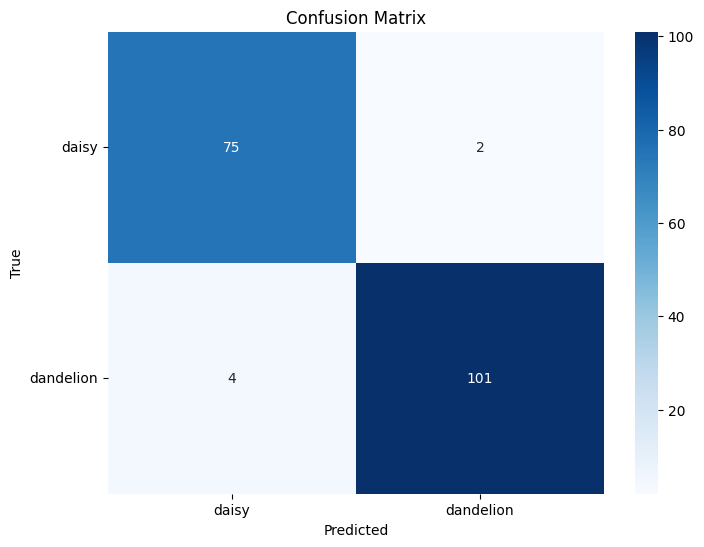


Results saved to: ./results/test_metrics.xlsx


In [19]:
# Cell 10: Final Test Evaluation
# choose epoch to load, e.g. best or specific
#epoch_to_test = 3

# Load Type--> 1 --> Best Validation Loss Model Checkpoint Loaded
# Load Type--> 2 --> Best Validation Accuracy Model Checkpoint Loaded

load_type =2

# reload model & data
_, _, test_loader, class_names = get_dataloaders()
model = load_model(CFG['model_name'], len(class_names), load_type, CFG['save_path'])

# evaluate
acc, report_df, conf_df = evaluate_and_save(model, test_loader, class_names, save_dir='./results')

#print(f"Testing Accuracy of {CFG['model_name']} is: ", acc)

